<a href="https://colab.research.google.com/github/Abhishekbhagwat/CE9010/blob/master/CE9010ProjectCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection Model
__Completed by Abhishek (AB), Hong Jun (HJ), Yeng Sung (YS)__ - CE9010 17 April 2019 <br>
_Source of Dataset: Kaggle_

## Table of Content
1. Introduction (HJ)
2. Data Extraction / Acquisition (Using API) (AB)
3. Data Exploration and Visualisation (HJ & YS)
4. Choice of performance metrics (HJ)
5. PreProcessing (AB)
6. Model Consideration <br>


*   Random Forest (HJ)
*   XGBoost (AB)
*   Logistic Regression (Code - AB, Text - YS)


7. Conclusion (AB)
8. Limitation and Further Research (HJ)
9. References

# 1. Introduction

## Context and Purpose

The number of credit card fruad incidents has been increasing in Singapore for the past few years. Such transactions are costly not only to the companies but it is also a social issue as such making transactions are crime. <br>
<br>
Main __purpose of this project__ is to _build a model that predicts whether a transaction is a fraudulent transaction or non-fraudulent transaction_. This can help to minimise such issues and also help reduce fraud handling cost incurred by the credit card companies. <br>
<br>
If the model predicts positive, the company can decide the decline the transaction as a preventive measure of reducing fraudulent transaction. This would help to minimise the amount of resources wasted on handling such transactions.

## About the Dataset
The data contains transaction details made in 2013 by European cardholders. The size of the data is 284,807. Ths data is highly unbalanced hence __pre-processing__ has to be done. This will be discussed in one of the sections.

There are 28 PCA-transformed features in the dataset and 2 other features - amount of transaction and time of transaction. As the 28 features are PCA-transformed, they are anonymised therefore limited insights could be drawn. Characteristics of the datasets would be further discussed in the other section of the report - __EDA__.


More details can be found here: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [0]:
#Import libraries

# numpy 
import numpy as np

# Pandas
import pandas as pd

# Visualisation
%matplotlib inline
import seaborn as sns
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Ignore Warning
import warnings
warnings.filterwarnings("ignore")

import json

# For pre-processing (Replace the NaN Values)
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer # Used in preprocessing_data
import random # Used in equal_split


# imblearn library used to oversample data - Using SMOTE + Tomek links
from imblearn.combine import SMOTETomek
from sklearn.model_selection import StratifiedKFold

# For GridSearch - HyperParameter tuing
from sklearn.model_selection import GridSearchCV

# Logistic Regression model
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression


# Random Forest library
from sklearn.ensemble import RandomForestClassifier

# Scoring and metrics
from sklearn.metrics import precision_score, recall_score, fbeta_score, confusion_matrix, precision_recall_curve, accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import make_scorer

# XGBoost Library
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools    
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# 2. Data Extraction / Acquisition
We are using __Kaggle API__ to download the dataset for our project. Alternatively, the code for using Selenium and a custom webscraper is also provided, but is not the preferred method as there is a prompt for user credentials

## 1. Setup Kaggle API
Run the cells below for a successful setup.<br>
__WARNING : This setup code can be run only on Google Colab notebooks. For alternative sources, please  follow the setup guide on https://github.com/Kaggle/kaggle-api__ 



In [3]:
!pip install kaggle #Use pip to install Kaggle packages from GitHub

List your files by using `ls -a`. If there is a directory `.kaggle`, skip this cell, else create the directory by using

Since we will be handling `json` files in this step, import the `json` package. 
Then define the token to use the Kaggle API. You would require your username and you API key, which can be created in the __Account__ tab of your Kaggle profile. This triggers the download of `kaggle.json` file. Your token can be found there. This can then be replaced in the fields below. 

We will then write this token to the `kaggle.json` file in your Google Colab file directory. 

In [13]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
import json

token = {"username":"abhishekbhagwat","key":"dae4bec275bbf0278e61b497967d0f5b"}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

To secure your file and remove access to the other users using your local system, we can change the permission by running the cell below

`chmod 600`  file – owner can read and write


In [0]:
!chmod 600 /content/.kaggle/kaggle.json


We then proceed to copy the content of this current directory to the `.kaggle` folder present in the `root` directory

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

After copying the content, we can set the current working path as the `/content` directory

In [17]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


Now that we have the API all set up, we can go and download the dataset we will be using for the project. The dataset and its description can be found at  https://www.kaggle.com/mlg-ulb/creditcardfraud

We will skip to check whether local version of file is up to date, and force the file to download by using the `--force` flag.

In [18]:
ls

sample_data/


In [20]:
!kaggle datasets download -d mlg-ulb/creditcardfraud -p /content --force

 99% 65.0M/66.0M [00:01<00:00, 21.1MB/s]
100% 66.0M/66.0M [00:01<00:00, 44.1MB/s]


From the cell above, we can see the downloaded file is a zip, which is not a supported file type. We will now unzip the file 

In [21]:
!unzip \*.zip #unzipping will reveal a .csv file, which is a supported file type

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


Unzipping the file gives us a csv file, which is supported by Data Analysis packages like NumPy or pandas. We will now use pandas to wrangle the data

## Data Wrangling 

In [22]:
df = pd.read_csv("creditcard.csv")

print(df.shape)
print(df.columns)
df.head()

(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Now that we have the dataset prepared, we need to clean it up a bit. By observing some records, we can see that there are records which have a transaction error of 0.00, which is an anomaly. We will now drop all such records from the dataset. 

In [0]:
zeroTransactions = df.loc[df['Amount']==0.00].index

df.drop(zeroTransactions, inplace=True)

# 3. Data Exploration and Visualisation


In [24]:
df.describe()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,282982.000000,282982.000000,282982.000000,282982.000000,282982.000000,282982.000000,282982.000000,282982.000000,282982.000000,282982.000000,...,282982.000000,282982.000000,282982.000000,282982.000000,282982.000000,282982.000000,282982.000000,282982.000000,282982.000000,282982.000000
mean,94848.963528,-0.000349,-0.002017,-0.003293,-0.011987,-0.002241,-0.001304,0.002510,0.000028,0.001465,...,-0.000049,-0.001609,0.000147,0.000201,-0.000508,-0.001365,0.000254,0.000193,88.919401,0.001643
std,47482.459589,1.956749,1.650490,1.514216,1.404850,1.378815,1.331592,1.233940,1.191173,1.099061,...,0.732650,0.725575,0.623032,0.605795,0.520985,0.481928,0.402986,0.330351,250.824374,0.040503
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.320155,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.010000,0.000000
25%,54251.250000,-0.920128,-0.602287,-0.893646,-0.853056,-0.693746,-0.769031,-0.551877,-0.208947,-0.642803,...,-0.228981,-0.543990,-0.161743,-0.354714,-0.317651,-0.327900,-0.070787,-0.052889,5.990000,0.000000
50%,84707.500000,0.016891,0.062913,0.177459,-0.025952,-0.055518,-0.276678,0.041956,0.021510,-0.050516,...,-0.030056,0.004981,-0.011071,0.040981,0.015640,-0.054345,0.001340,0.011318,22.490000,0.000000
75%,139363.750000,1.315431,0.803483,1.022961,0.731168,0.610334,0.394015,0.571967,0.326754,0.598954,...,0.186199,0.527042,0.148023,0.439992,0.350331,0.239661,0.091351,0.078438,78.000000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


## A. Class Distribution

The class is very skewed. Only 0.02% of the data is fraudulent transactions. Therefore, pre-processing has to be done. In the following sections, we would be using SMOTE to get more balanced data so that the model would have a higher recall.





No Frauds 99.84 % of the dataset
Frauds 0.16 % of the dataset
No Frauds 282517  of the dataset
Frauds 465  of the dataset


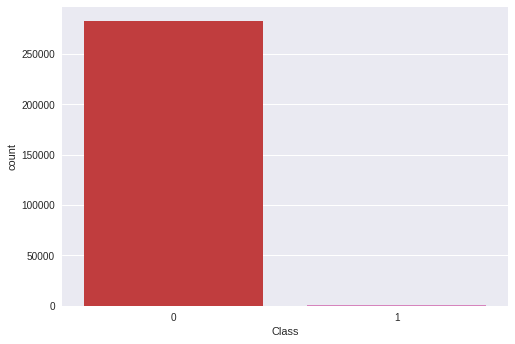

In [25]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
print('No Frauds', round(df['Class'].value_counts()[0],2), ' of the dataset')
print('Frauds', round(df['Class'].value_counts()[1],2), ' of the dataset')

sns.countplot('Class', data=df, palette= "tab10")


## B. Time

(0.13111111111111112, 47.318888888888885)

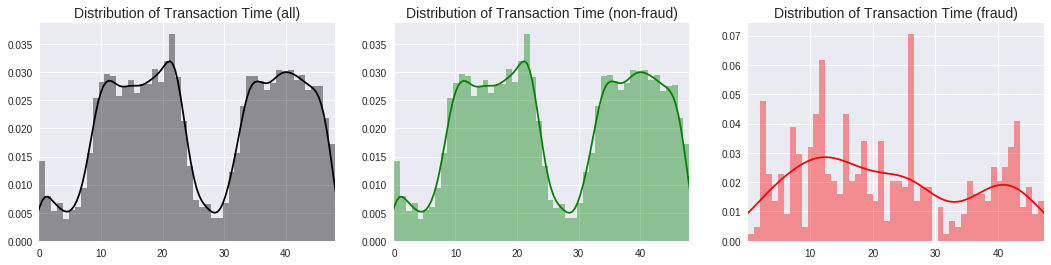

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(18,4))

time_val = df['Time'].values/3600

sns.distplot(time_val, ax=ax[0], color='black')
ax[0].set_title('Distribution of Transaction Time (all)', fontsize=14)
ax[0].set_xlim([min(time_val), max(time_val)])


time_val = df[df["Class"] == 0]['Time'].values/3600
sns.distplot(time_val, ax=ax[1], color='g', bins = 50)
ax[1].set_title('Distribution of Transaction Time (non-fraud)', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])


time_val = df[df["Class"] == 1]['Time'].values/3600
sns.distplot(time_val, ax=ax[2], color='r', bins = 50)
ax[2].set_title('Distribution of Transaction Time (fraud)', fontsize=14)
ax[2].set_xlim([min(time_val), max(time_val)])



We can see that there is a clear pattern for non-fraud data over time. However, no specific pattern can be identified for fraud data.

## C. Amount



(0.01, 800)

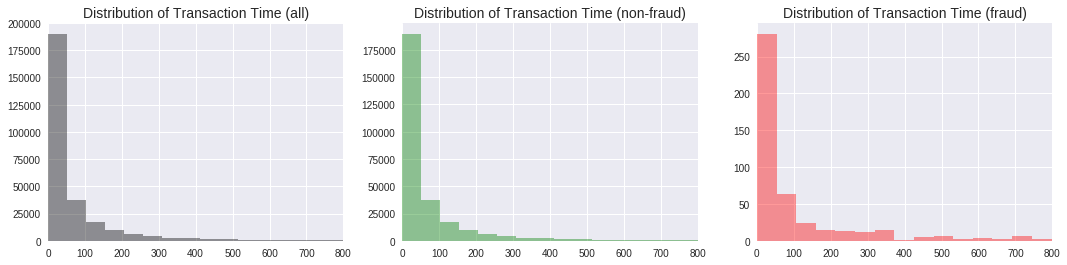

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(18,4))

amt_val = df['Amount'].values

sns.distplot(amt_val, ax=ax[0], color='black', bins = 500, kde = False)
ax[0].set_title('Distribution of Transaction Time (all)', fontsize=14)
ax[0].set_xlim([min(amt_val), 800])


amt_val = df[df["Class"] == 0]['Amount'].values
sns.distplot(amt_val, ax=ax[1], color='g', bins = 500, kde = False)
ax[1].set_title('Distribution of Transaction Time (non-fraud)', fontsize=14)
ax[1].set_xlim([min(amt_val), 800])


amt_val = df[df["Class"] == 1]['Amount'].values
sns.distplot(amt_val, ax=ax[2], color='r', bins = 40, kde = False)
ax[2].set_title('Distribution of Transaction Time (fraud)', fontsize=14)
ax[2].set_xlim([min(amt_val), 800])




Based on the visualisation, we can clearly identy that most of the transactions are low valued. About 80% of the fraud transactions are below $150. Based on this, this may misdirect our thinking that we should focus on the low amount transaction. However, that is not correct. The following section would discuss why.




### C1.Applying Pareto Rule

From the pie charts below, we can conclude pareto principle applies. And therefore, the implication is that
although 80% of the fraudulent transactions are less than $150, they only make up 20% of entire fraud value. 
The other 20% of the data is the one that costs a lot, which makes up 80% of all the fraud values.<br>

Therefore, preventing the 20% of the fraud transactions (more than $150) effectively solves 80% of the entire fraud issues. 


In [0]:
def percentage_cut(cut = 95, df = df):
    total = sum(df["Amount"])
    totalcount = len(df["Amount"])

    high_freq = len(df[(df["Amount"] > cut)]["Amount"])
    low_freq = len(df[(df["Amount"] < cut)]["Amount"])

    high_amt= round(sum(df[df["Amount"] > cut]["Amount"]),2)
    low_amt = round(sum(df[df["Amount"] <= cut]["Amount"]),2)

    print("By Frequency")
    print("    Higher than $", cut, ": ", high_freq, "(",round(high_freq / totalcount * 100,2),"%)")
    print("    Lower than $", cut, ": ", low_freq, "(",round(low_freq / totalcount * 100,2),"%)")

    print("By Amount")
    print("    Higher than $", cut, ": ", high_amt, "(",round(high_amt / total * 100,2),"%)")
    print("    Lower than $", cut, ": ", low_amt, "(",round(low_amt / total * 100,2),"%)")

    # Plot in terms of frequency (number of transactions)
    labels = ['Low', 'High']
    sizes = [low_freq,high_freq]
    colors = ['royalblue', 'darkorange']
    a, patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, autopct="%1.1f%%")
    plt.legend(patches, labels = labels, loc="best")
    plt.axis('equal')
    plt.title("By Frequency")
    plt.tight_layout()
    plt.show()

    # Plot in terms of Amount (Transaction Values)
    labels = ['Low', 'High']
    sizes = [low_amt, high_amt]
    colors = ['royalblue', 'darkorange']
    a, patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, autopct="%1.1f%%")
    plt.legend(patches, labels = labels, loc="best")
    plt.axis('equal')
    plt.title("By Amount")
    plt.tight_layout()
    plt.show()

By Frequency
    Higher than $ 95 :  60029 ( 21.25 %)
    Lower than $ 95 :  222334 ( 78.7 %)
By Amount
    Higher than $ 95 :  19992449.41 ( 79.64 %)
    Lower than $ 95 :  5110012.63 ( 20.36 %)


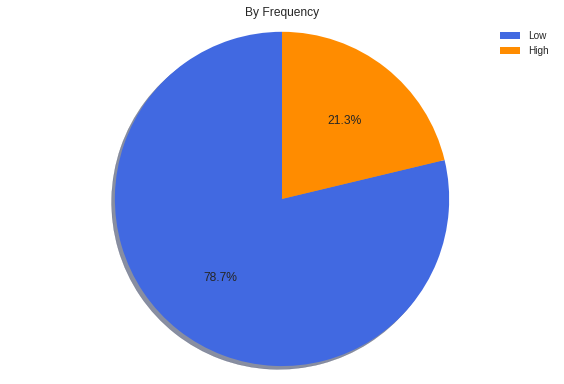

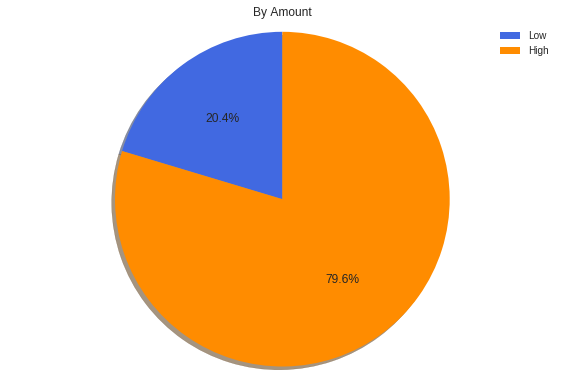

In [29]:
# Non-Fraud Transactions
percentage_cut(95, df[df["Class"] == 0])

By Frequency
    Higher than $ 150 :  99 ( 21.29 %)
    Lower than $ 150 :  366 ( 78.71 %)
By Amount
    Higher than $ 150 :  49461.94 ( 82.26 %)
    Lower than $ 150 :  10666.03 ( 17.74 %)


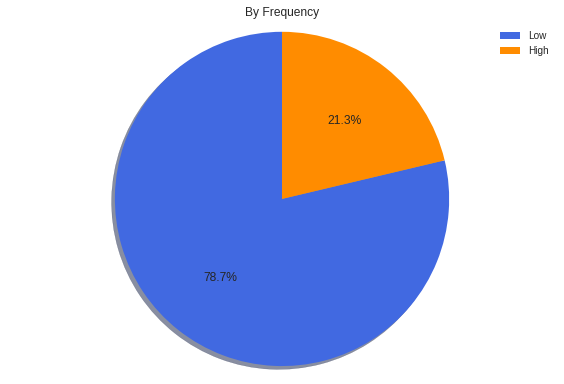

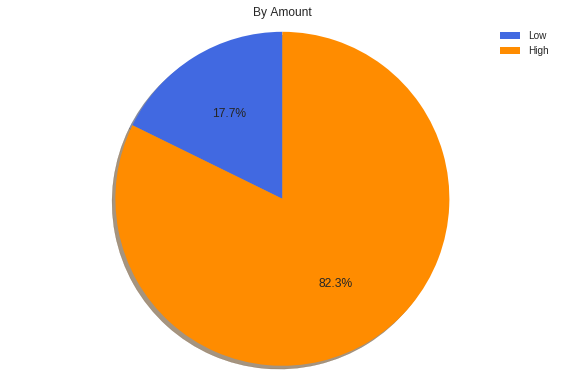

In [30]:
# Fraud Transadftions
percentage_cut(150, df[df["Class"] == 1])

## D. Scatter Plot of each features (Fraud vs Non-Fraud)

__Scatterplots__ were plotted for each features against the time with the hue being the 
class (green dots refer to fraudulent data and blue dots refer to non-fraudulent data).  <br>
This is to get a general idea on how the features are distributed and visualise if there is a clear distinctive line 
between the fraudulent and non-fraudulent data. As it can be seen in the graphs, for features such as V12, V14 and V17, we can see that the data __overlap less than the other features__. <br>
This implies that these features could be more useful features when we are making a prediction on whether a transaction is fraud or non-fraud. <br>
We will see how each model react to these features by looking at the feature importance (or weights) given to each features.



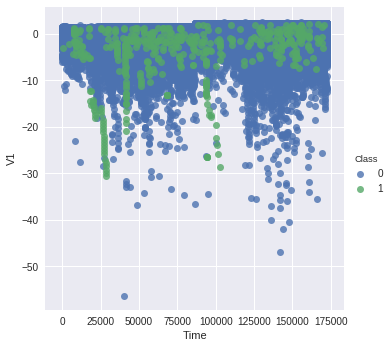

In [31]:
sns.lmplot(data = df, x = "Time", y= "V1", hue = "Class",fit_reg  = False)

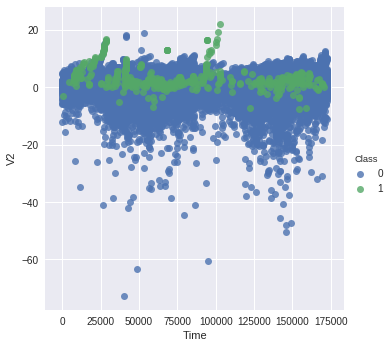

In [32]:
sns.lmplot(data = df, x = "Time", y= "V2", hue = "Class",fit_reg  = False)

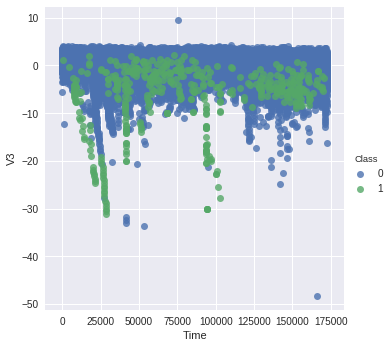

In [33]:
sns.lmplot(data = df, x = "Time", y= "V3", hue = "Class",fit_reg  = False)

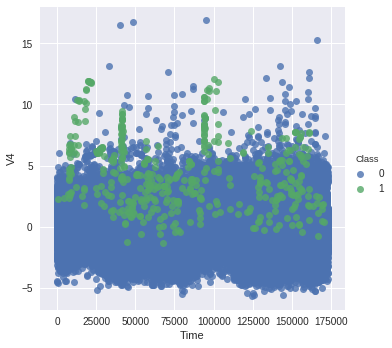

In [34]:
sns.lmplot(data = df, x = "Time", y= "V4", hue = "Class",fit_reg  = False)

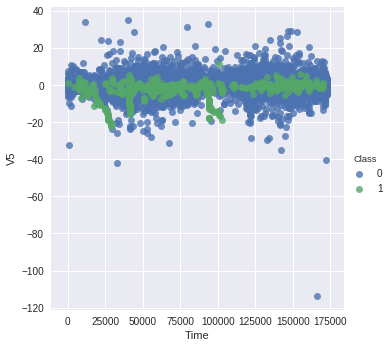

In [35]:
sns.lmplot(data = df, x = "Time", y= "V5", hue = "Class",fit_reg  = False)

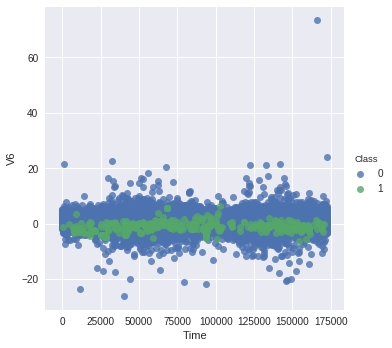

In [36]:
sns.lmplot(data = df, x = "Time", y= "V6", hue = "Class",fit_reg  = False)

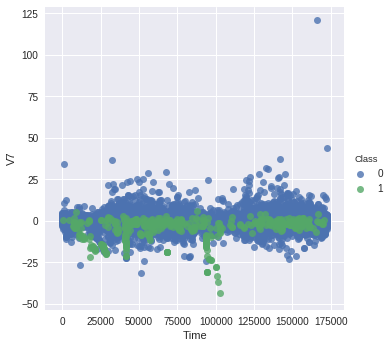

In [37]:
sns.lmplot(data = df, x = "Time", y= "V7", hue = "Class",fit_reg  = False)

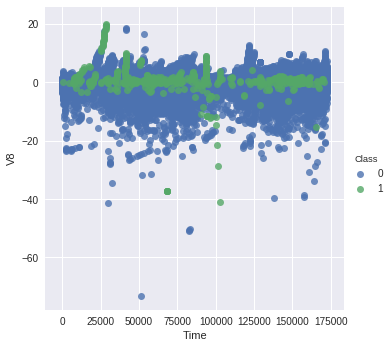

In [38]:
sns.lmplot(data = df, x = "Time", y= "V8", hue = "Class",fit_reg  = False)

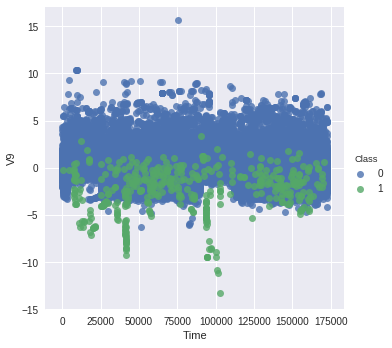

In [39]:
sns.lmplot(data = df, x = "Time", y= "V9", hue = "Class",fit_reg  = False)

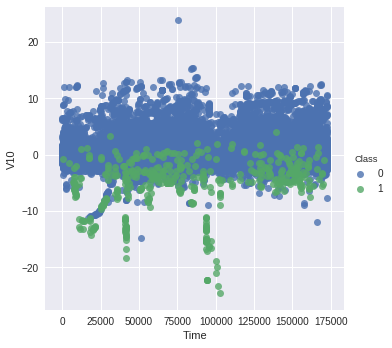

In [40]:
sns.lmplot(data = df, x = "Time", y= "V10", hue = "Class",fit_reg  = False)

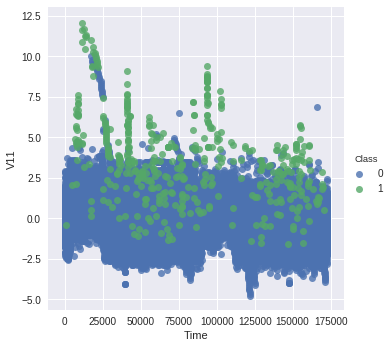

In [41]:
sns.lmplot(data = df, x = "Time", y= "V11", hue = "Class",fit_reg  = False)

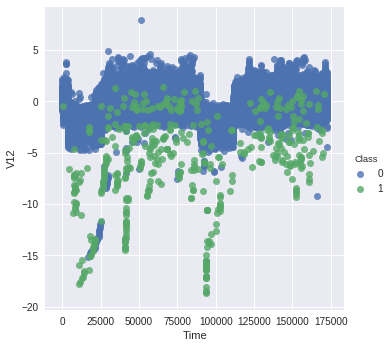

In [42]:
sns.lmplot(data = df, x = "Time", y= "V12", hue = "Class",fit_reg  = False)

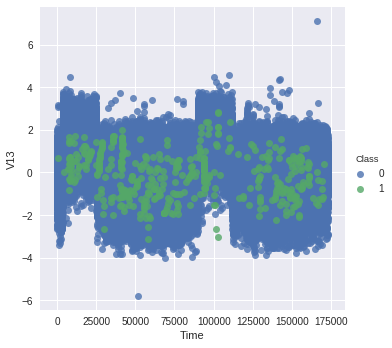

In [43]:
sns.lmplot(data = df, x = "Time", y= "V13", hue = "Class",fit_reg  = False)

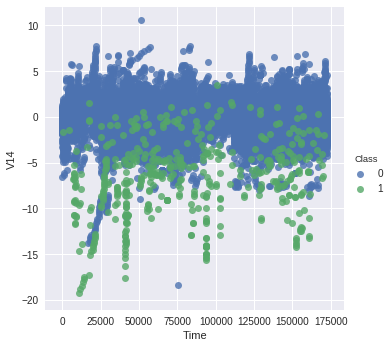

In [44]:
sns.lmplot(data = df, x = "Time", y= "V14", hue = "Class",fit_reg  = False)

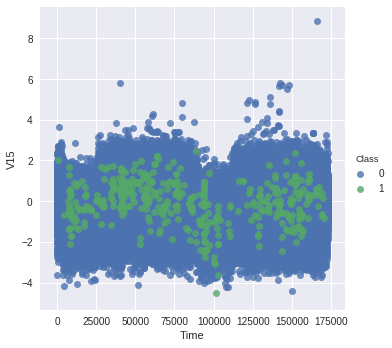

In [45]:
sns.lmplot(data = df, x = "Time", y= "V15", hue = "Class",fit_reg  = False)

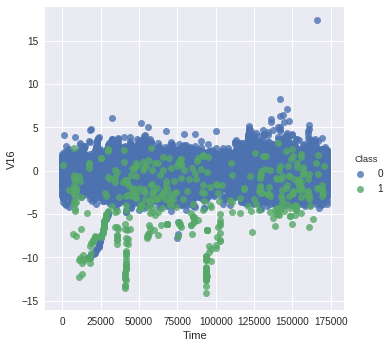

In [46]:
sns.lmplot(data = df, x = "Time", y= "V16", hue = "Class",fit_reg  = False)

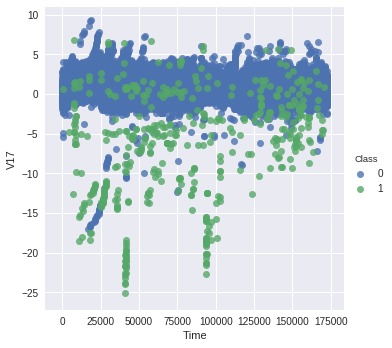

In [47]:
sns.lmplot(data = df, x = "Time", y= "V17", hue = "Class",fit_reg  = False)

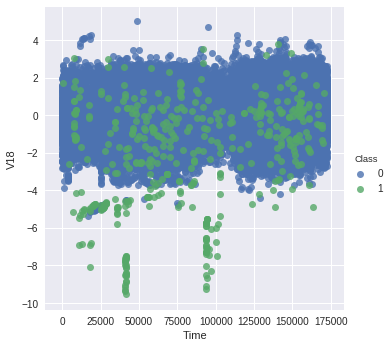

In [48]:
sns.lmplot(data = df, x = "Time", y= "V18", hue = "Class",fit_reg  = False)

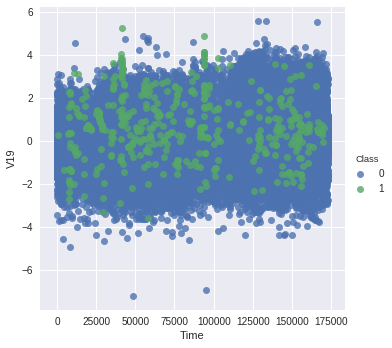

In [49]:
sns.lmplot(data = df, x = "Time", y= "V19", hue = "Class",fit_reg  = False)

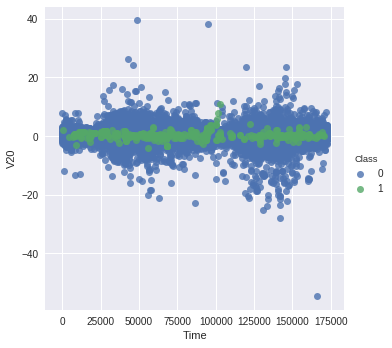

In [50]:
sns.lmplot(data = df, x = "Time", y= "V20", hue = "Class",fit_reg  = False)

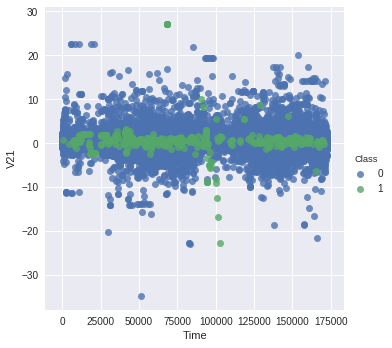

In [51]:
sns.lmplot(data = df, x = "Time", y= "V21", hue = "Class",fit_reg  = False)

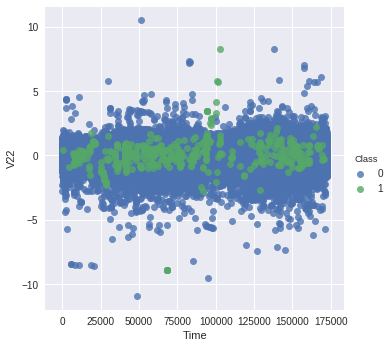

In [52]:
sns.lmplot(data = df, x = "Time", y= "V22", hue = "Class",fit_reg  = False)

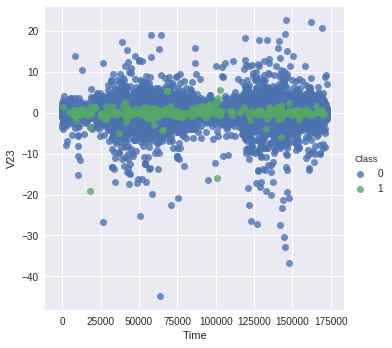

In [53]:
sns.lmplot(data = df, x = "Time", y= "V23", hue = "Class",fit_reg  = False)

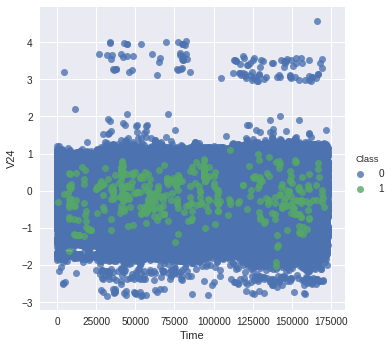

In [54]:
sns.lmplot(data = df, x = "Time", y= "V24", hue = "Class",fit_reg  = False)

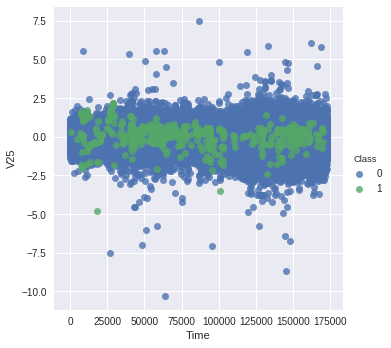

In [55]:
sns.lmplot(data = df, x = "Time", y= "V25", hue = "Class",fit_reg  = False)

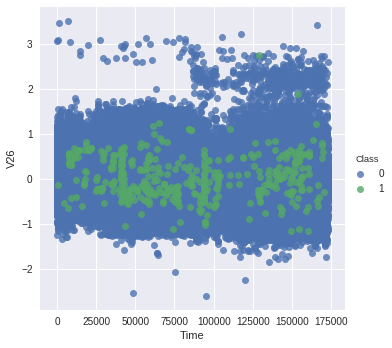

In [56]:
sns.lmplot(data = df, x = "Time", y= "V26", hue = "Class",fit_reg  = False)

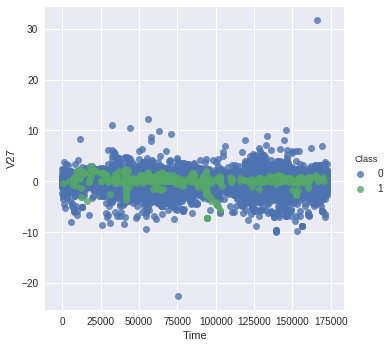

In [57]:
sns.lmplot(data = df, x = "Time", y= "V27", hue = "Class",fit_reg  = False)

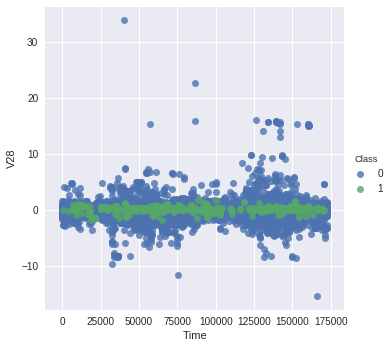

In [58]:
sns.lmplot(data = df, x = "Time", y= "V28", hue = "Class",fit_reg  = False)

## Correlation matrix

Based on the features, correlation matrix was plotted. However, there was no correlation found between the PCA transformed features.

Text(0.5, 1.0, 'Correlation Matrix')

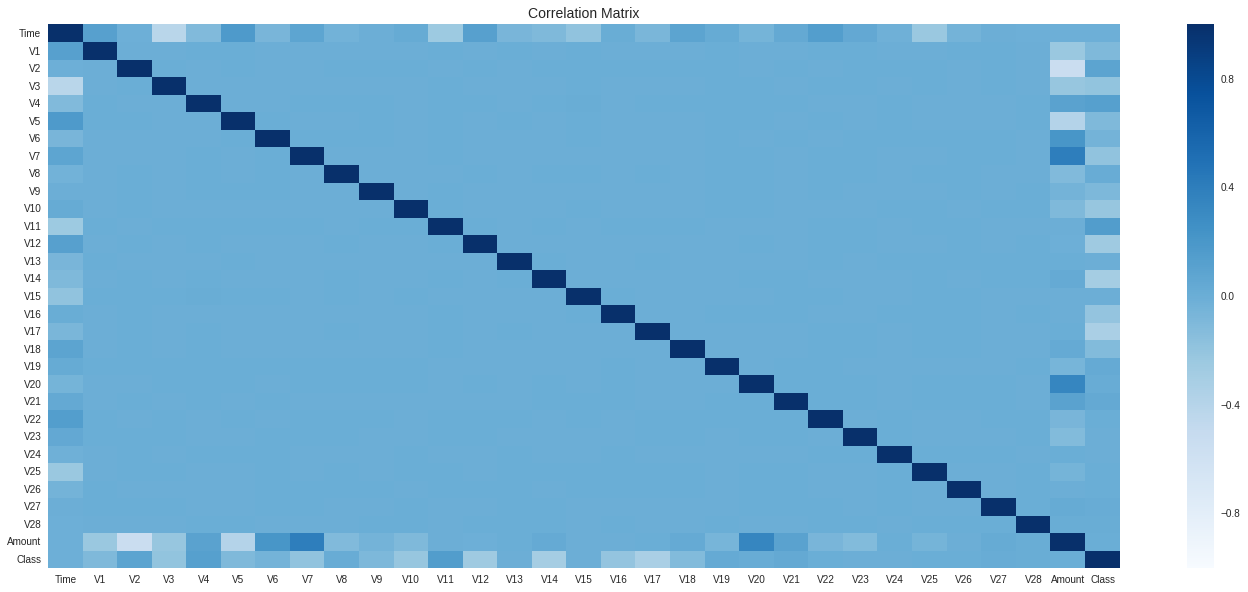

In [59]:
f, ax1 = plt.subplots(1, 1, figsize=(24,10))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='Blues', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Correlation Matrix", fontsize=14)

# 4. Choice of Performance metric

For classification, there are various performance metrics that can be used. Some of the examples are accuracy, precision, accuracy and F1 score. <br>

However, in the context of this dataset, __accuracy is not a a good performance metric__. _A model that predicts all data to be non-fraudulent is still likely to give an accuracy of about 99%, as most of the transactions are indeed genuine transaction._ Therefore, accuracy does not explain how well the model predicts the frudulent transaction. <br>

For the purpose of this project, __F1 score__ will be the main metric used for measuring the performance. Precision and recall can also be used.

__The formula of F1 score is:
2 x (precision x recall) / (precision + recall)__

# 5. Pre-processing of data

## Separating Features and Labels

The next step is to identify the columns which are used as the features and the columns which are used as labels. For our dataset we want to predict the class, therefore, it will the label and the rest of the columns will be classified as features.  

In [60]:
feature_names = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
label_name = "Class"

print(feature_names)
print(label_name)

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
Class


Creating `DataFrames` of the features and label

In [61]:
X = df[feature_names]
print(X.shape)
X.head()  

(282982, 30)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [62]:
Y = df[label_name]
print(Y.shape)
Y.head()

(282982,)


0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

## SMOTE + Tomek (To process imbalanced data)
SMOTE + Tomek Combines over- and under-sampling using SMOTE and cleaning up using Tomek links.

Tomek links can be used as an under-sampling method or as a data cleaning method. Tomek links to the over-sampled training set as a data cleaning method. Thus, instead of removing only the majority class examples that form Tomek links, examples from both classes are removed

![alt text](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/tomek.png?v=2)

Documentation can be found here https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.combine.SMOTETomek.html

Initialize Class to perform over-sampling using SMOTE and cleaning using Tomek links.<br>
We also specify the `sampling_strategy` parameter to 0.05 manually, to set the ratio of the minority class to majority class samples.
the ratio is expressed as $\alpha$	 = N<sub>M</sub> / N<sub>rm</sub> where  N<sub>M</sub> and N<sub>rm</sub> are the number of samples in the minority class after resampling and the number of samples in the majority class, respectively.



In [0]:
STK = SMOTETomek(0.05)
stkx, stky = STK.fit_sample(X, Y)

In [64]:
stkx.shape

(294898, 30)

In [65]:
stky.shape

(294898,)

The returned data structures are arrays or lists. To use this data in `pandas`, we have to convert them to `DataFrames`. We also must combine both `stkx` and `stky` into a single dataset, similar to `df` to perform further operations. Therefore we create a new column `Class` and assign it `stky`.


In [66]:
df1 = pd.DataFrame(stkx, columns = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'] )

df1["Class"] = pd.Series(stky)

X = df1[feature_names]
Y = df1[label_name]

X.shape


(294898, 30)

In [67]:
len(df[df["Class"] == 1]) #The number of minority class elements in the original dataset

465

In [68]:
len(df1[df1["Class"] == 1]) #The number of minority class elements in the new dataset, after oversampling. Observe that the ratio is near to 0.02

13253

We now plot the comparison of majority class vs. minority class elements for both the datasets.

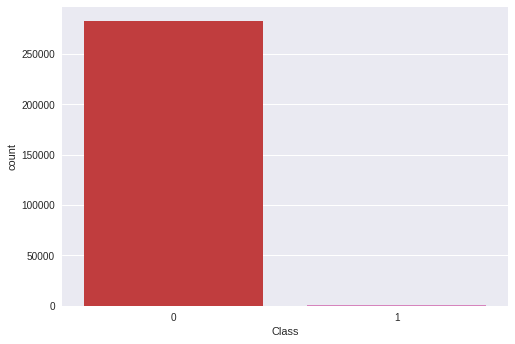

In [69]:
sns.countplot('Class', data=df, palette= "tab10")

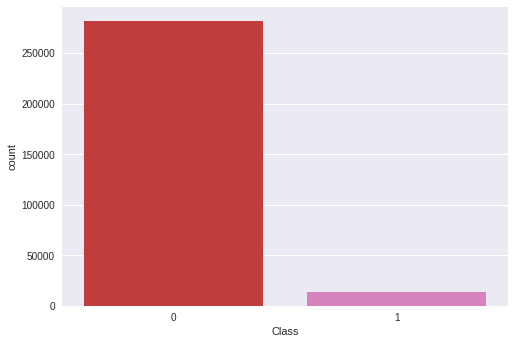

In [70]:
sns.countplot('Class', data=df1, palette= "tab10")

## Stratified K - fold cross validation
Cross Validation is a technique which involves reserving a particular sample of a dataset on which you do not train the model.

Here are the steps involved in cross validation:

+ You reserve a sample data set
+ Train the model using the remaining part of the dataset
+ Use the reserve sample of the test (validation) set. This will help you in gauging the effectiveness of your model’s performance.
+ If your model delivers a positive result on validation data, go ahead with the current model.

There are many cross validation techniques, but we have chosen to use, __Stratified k-fold cross validation__.<br><br>
It is generally a better approach when dealing with both bias and variance. A randomly selected fold might not adequately represent the minor class, particularly in cases where there is a huge class imbalance.



In [71]:
# K - fold cross validation

y = np.array(df1.Class.tolist())
df1 = df1.drop('Class', 1)
X = np.array(df1.as_matrix())

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
for train_index, test_index in skf.split(X, y):
    X_train, y_train = X[train_index], Y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    

print(X.shape)
print(X_train.shape)
print(X_test.shape)

(294898, 30)
(235919, 30)
(58979, 30)


# 6. Model Consideration

Random forest, XG Boost and Logistic Regression would be compared to see which model provides the best prediction. <br>

f1 score will be used to evaluate the performance of the model

# **6A. Logistic Regression**

**Logistic regression** is a supervised learning technique for classification given a set of data features. The prediction function of the model is a *logistic regression function* (probability function) which can be used to determine the boundary decision, and compute logistic regression loss and gradient descent. 

## Model Representation

*   The model is represented by the LogisticRegression imported from sklearn and the regularization parameter will be determined in the next few steps.




In [0]:
# call the classifier and train the data
clf_logistic = LogisticRegression();
clf_logistic.fit(X_train, y_train);

## Evaluation on Accuracy of Data


*   Based on the default hyper parameter (= 0.1), the confusion matrix is formed, followed by computation of accuracy, precision, recall and F1 score. 

*   The area under the Receiver Operating Characteristic (ROC) curve is also computed. The larger the area, the better the output quality of the classifier.





In [73]:
y_pred = clf_logistic.predict(X_test);
print(metrics.confusion_matrix(y_test,y_pred));
print(metrics.classification_report(y_test,y_pred));
print('Accuracy : %f' %(metrics.accuracy_score(y_test,y_pred)));
print('Area under the curve : %f' %(metrics.roc_auc_score(y_test,y_pred)));

[[56160   169]
 [  449  2201]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     56329
           1       0.93      0.83      0.88      2650

   micro avg       0.99      0.99      0.99     58979
   macro avg       0.96      0.91      0.94     58979
weighted avg       0.99      0.99      0.99     58979

Accuracy : 0.989522
Area under the curve : 0.913783


## Hyper parameter Tuning


*   To learn the hyper parameters of the logistic regression function, cross-validation method is used. Several values of hyper parameter are listed and the best one is determined.



In [0]:
def cv_run(X_train, y_train):
    bestC = 1.
    bestScore = 0.
    for C in [0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]:
        lr = linear_model.LogisticRegression(C=C) # use of another instance of model, to avoid conflicts
        lr.fit(X_train, y_train)
        y_pred_train=lr.predict(X_train)
        score = f1_score(y_train, y_pred_train)
        if score > bestScore:
            bestC = C
            bestScore = score
    print( "Best C:", bestC)
    
    

In [76]:
cv_run(X_train, y_train)


Best C: 0.1


## Fitting the Model and Evaluation

*   Using the hyper parameter that was computed before (which is the same as the default hyper parameter), accuracy, precision, recall and F1 score are evaluated again. Confusion matrix is also constructed. 




In [0]:
def print_results(headline, true_value, pred):
    print(headline)
    print("accuracy: {}".format(accuracy_score(true_value, pred)))
    print("precision: {}".format(precision_score(true_value, pred)))
    print("recall: {}".format(recall_score(true_value, pred)))
    print("f1: {}".format(fbeta_score(true_value, pred, beta=1)))



*   Although the calculated accuracy is high, it is best to use F1 score for evaluation because F1 score is the weighted average of the precision and recall.



In [78]:
lr = linear_model.LogisticRegression(C=0.1)
lr.fit(X_train, y_train)
y_pred_test=lr.predict(X_test)
    
print(confusion_matrix(y_test, y_pred_test))
print_results("Optimised Logistic Regression", y_test, y_pred_test)

[[56160   169]
 [  449  2201]]
Optimised Logistic Regression
accuracy: 0.9895216941623289
precision: 0.9286919831223629
recall: 0.830566037735849
f1: 0.8768924302788843


## Receiver Operating Characteristic (ROC) Curve


*  ROC curve is used to evaluate the classifier output quality. The ideal point is on the top left corner of the plot where true positive rate is one and false positive rate is zero. 

*   From the plot, it could be seen that the true positive rate is considerably high and is near to the ideal point. This indicates that the logistic regression may be a good classifier.





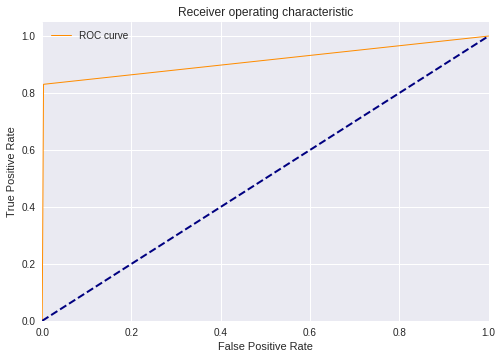

In [79]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=True)

plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="best")
plt.show()

# 6B. Random Forest

__Random forest__ is a learning meathod for both classification and regression. It construct multiple __decision trees__ for training and output the class that is the mode of the classes of individual trees.  <br>




Below is the model to be used. Hyperparamers has to be re-tuned in the following sections. <br>
__n_jobs__ was put to -1 to maximise the computational power.<br>

In [80]:
model = RandomForestClassifier(max_features=3, max_depth=2 ,n_estimators=10, random_state=3 , n_jobs=-1)
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=3, verbose=0, warm_start=False)

### Hyper parameter tuning

These __parameters of the grids__ are for the purpose of hyperparameter tuning. 
With more computational power, more possible values can be run to find the optimal hyperparameters. <br>
For the purpose of project, our team limited the grid to as follow

In [0]:
#params of the model
param_grid = {"max_depth": [None, 3,5],
              "n_estimators":[3,5,10],}
#               "max_features": [10, 15, 20]}

Grid search uses 5 folds (CV) (stratifiedKFold) for the train and validation splits.
For the scoring, __F1 score__ is used.

In [0]:
grid_search = GridSearchCV(model, param_grid=param_grid, scoring='f1')

In [83]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=3, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [None, 3, 5], 'n_estimators': [3, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [84]:
grid_search.best_score_

0.8816909207178077

In [85]:
grid_search.best_params_

{'max_depth': 3, 'n_estimators': 3}

Above are the hyperparamers to be used to maximise F1 score.


## Fitting the model and Evaluation (Random Forest)


In [86]:
rfmodel = RandomForestClassifier(max_depth=3, n_estimators = 3)
rfmodel.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=3, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [87]:
print("Training score data: ", round(rfmodel.score(X_train, y_train) * 100, 2), '%')

Training score data:  99.37 %


The mean accuracy of the model is extremely high (But this is due to the imbalanced data. F1 score has to be used).


In [0]:
def print_results(headline, true_value, pred):
    print(headline)
    print("accuracy: {}".format(accuracy_score(true_value, pred)))
    print("precision: {}".format(precision_score(true_value, pred)))
    print("recall: {}".format(recall_score(true_value, pred)))
    print("f1: {}".format(fbeta_score(true_value, pred, beta=1)))

In [89]:
Y_pred = rfmodel.predict(X_test)

print(confusion_matrix(y_test, Y_pred))
print_results("RF classification", y_test, Y_pred)

[[56270    59]
 [  336  2314]]
RF classification
accuracy: 0.9933027009613591
precision: 0.9751369574378423
recall: 0.8732075471698113
f1: 0.921361736014334


## Finding the weight given to each features (Random Forest)


In [90]:
# Feature importance values
rfmodel.feature_importances_

array([0.00000000e+00, 1.44006974e-03, 4.45907226e-04, 0.00000000e+00,
       6.59524121e-03, 0.00000000e+00, 0.00000000e+00, 4.72373011e-05,
       0.00000000e+00, 1.06976422e-02, 2.90531910e-01, 0.00000000e+00,
       4.04514848e-04, 0.00000000e+00, 6.42230864e-01, 7.60540051e-05,
       1.74416793e-02, 1.80816786e-02, 5.98015676e-03, 0.00000000e+00,
       0.00000000e+00, 3.25685101e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.13811449e-03, 6.32079192e-04])

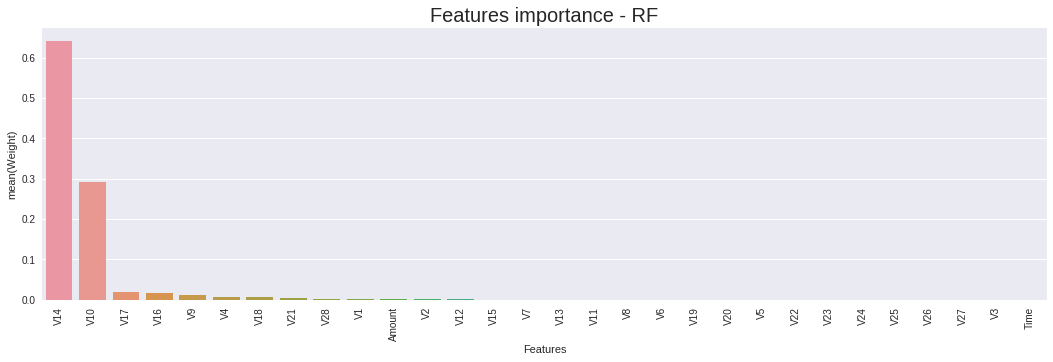

In [91]:
plt.figure(figsize = (18,5))

importance = pd.DataFrame({'Features': feature_names, 'Weight': rfmodel.feature_importances_})
importance = importance.sort_values(by='Weight',ascending=False)

g = sns.barplot(x='Features',y='Weight',data=importance)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title('Features importance - RF',fontsize=20)
plt.show() 



## ROC Curve (Random Forest)


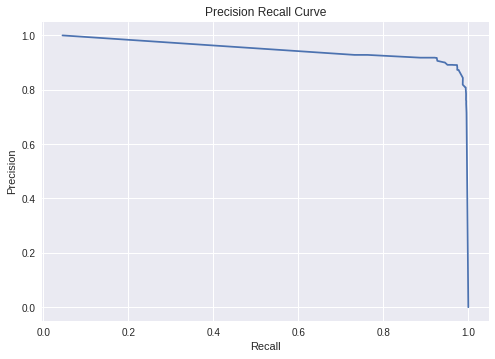

In [92]:
#Predicting proba
Y_pred_prob = rfmodel.predict_proba(X_test)[:,1]

# Generate precision recall curve values: precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, Y_pred_prob)

# Plot ROC curve
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

## Cross validation Score (Random Forest)


In [93]:
results = cross_val_score(rfmodel,X_train, y_train, cv=5, scoring='f1')
results

array([0.73076085, 0.90684508, 0.87058824, 0.93753074, 0.89769821])

## AUC Curve (Random Forest)

AUC: 0.963


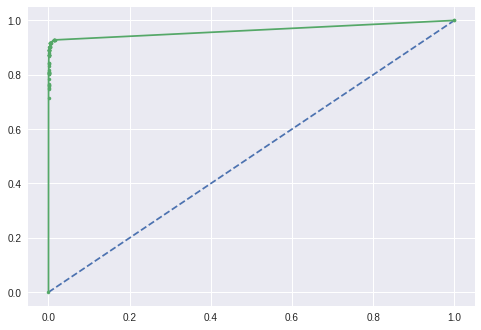

In [94]:
probs = rfmodel.predict_proba(X_test)

probs = probs[:, 1]

# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

matplotlib.pyplot.plot([0, 1], [0, 1], linestyle='--')

matplotlib.pyplot.plot(fpr, tpr, marker='.')

matplotlib.pyplot.show()

# 6C. XGBoost Model

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.

The documentation can be found at https://xgboost.readthedocs.io/en/latest/index.html

### Evaluation Metrics 
    + precision: tp/(tp+fp) percentage of correctly classified predicted positives
    + recall: tp/(tp+fn) percentage of positives correctly classified
    + F-score with beta=1
    + fscore <- 2*precision.neg*recall.neg/(precision.neg+recall.neg)

In [0]:
def show_metrics():
  tp = cm[1,1]
  fn = cm[1,0]
  fp = cm[0,1]
  tn = cm[0,0]
  print('Precision =     {:.3f}'.format(tp/(tp+fp)))
  print('Recall    =     {:.3f}'.format(tp/(tp+fn)))
  print('F1_score  =     {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))

In [0]:
# Plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
# Plot a precision - recall curve 

def plot_precision_recall():
    plt.step(recall, precision, color = 'b', alpha = 0.2,
             where = 'post')
    plt.fill_between(recall, precision, step ='post', alpha = 0.2,
                 color = 'b')

    plt.plot(recall, precision, linewidth=2)
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.show();

In [0]:
# Plot a ROC curve
def plot_roc():
  plt.plot(fpr, tpr, color='darkorange',
           lw=1, label='ROC curve')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="best")
  plt.show()

In [0]:
# Feature Importance

predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

# Plotting of Feature Importance
def plot_feature_importance(model):
    tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': model.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance',ascending=False)
    plt.figure(figsize = (15,8))
    plt.title('Features importance',fontsize=14)
    s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()


The model is initialised here below. Hyperparameters has to be re-tuned in the following sections. <br>
__n_jobs__ was put to -1 to maximise the computational power.<br>


In this step, we will be training the model and using the k-fold cross validation method for prediction. 

These __parameters of the grids__ are for the purpose of hyperparameter tuning. 
With more computational power, more possible values can be run to find the optimal hyperparameters. <br>
For the purpose of project, our team limited the grid to as follow

In [100]:
# Search for the best XGB hyperparameters using GridSearch CV

param_grid = {
              'n_estimators': [50,100,150,200]
              }

xgb_cfl = XGBClassifier(n_jobs = -1)

CV_xgb_cfl = GridSearchCV(estimator = xgb_cfl, param_grid = param_grid, scoring ='f1', verbose = 2, n_jobs = -1) # verbose is set at 2 to check the debug log, as it takes quite some time to train
CV_xgb_cfl.fit(X_train, y_train)

best_parameters = CV_xgb_cfl.best_params_
print("The best parameters for using this model is", best_parameters)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  9.0min finished


The best parameters for using this model is {'n_estimators': 50}


In [0]:
# xgb
xgb_cfl = XGBClassifier(n_jobs = -1, n_estimators = 50)

xgb_cfl.fit(X_train, y_train)
y_pred = xgb_cfl.predict(X_test)
y_score = xgb_cfl.predict_proba(X_test)[:,1]

Now that the training of the model is complete, we will now proceed to plot the evaluation metrics of the model, including the  confusion matrix

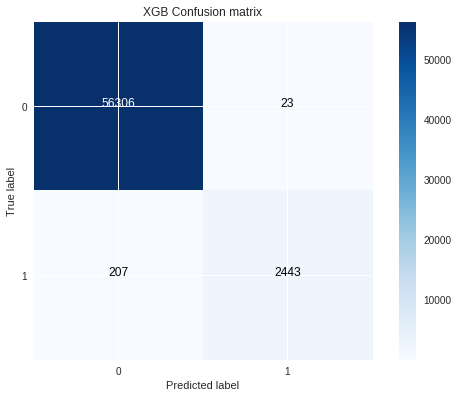

In [102]:
# Confusion Matrix and evaluation metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='XGB Confusion matrix')
plt.show()

cm = cm.astype(np.float64)



In [103]:
print("Evaluation metrics of the model with the current hyperparameters")
show_metrics()

Evaluation metrics of the model with the current hyperparameters
Precision =     0.991
Recall    =     0.922
F1_score  =     0.955


Plot of the ROC Curve

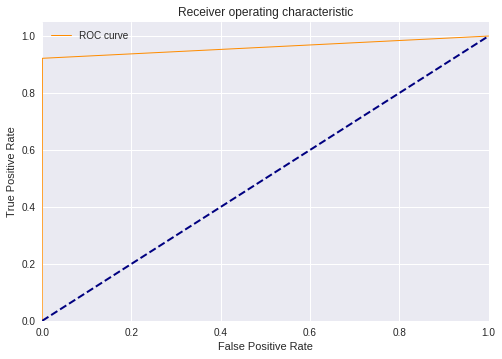

In [104]:
# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=True)
plot_roc()

Plot of the Precision - Recall Curve

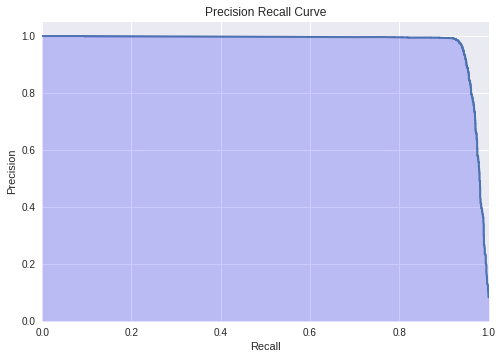

In [105]:
# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plot_precision_recall()

Plot of the feature importance<br>
The importance of a feature is the increase in the prediction error of the model after we permuted the feature’s values, which breaks the relationship between the feature and the true outcome.



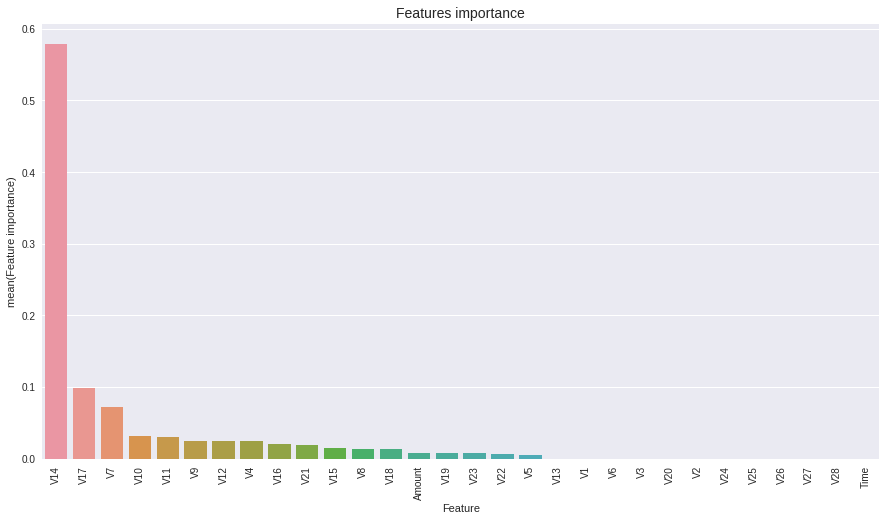

In [106]:
plot_feature_importance(xgb_cfl)

# 7. Conclusion

As mentioned above, we have used 3 metrics to evaluate our model -
1. Precision
2. Recall
3. F1 score<br>

Now that we know the metrics, let us evaluate our models based on this data<br><br>

| Model | Precision | Recall | F1 score |
|---|---|---|---|---|
| Linear Logistic Regression | 0.929 | 0.837 | 0.880 |
| Random Forest | 0.994 | 0.864 | 0.924 |
| XGBoost | 0.990 | 0.921 | 0.954 |
<br>

GBM and RF differ in the way the trees are built: the order and the way the results are combined. It has been shown that GBM performs better than RF if parameters tuned carefully.
<br>
__Gradient Boosting__: GBT build trees one at a time, where each new tree helps to correct errors made by previously trained tree.

__Random Forest__: RFs train each tree independently, using a random sample of the data. This randomness helps to make the model more robust than a single decision tree, and less likely to overfit on the training data 

From the table above, you can notice that the main parameters required for the evaluation, Recall and F1 Score, __are the best for XGBoost__.<br>
Hence we can conclude that it is the best model which can predict credit card fraud activity most accurately.

# 8. Limitations and Further Research

#### 1. Anonymised Features
- Limited insights could be extracted as we could not identify what each features meant. More meaningful insights could be drawn if we had access to the context of the features
- For example, behavioural analytics may be used and separate models can be built for each cardholder to learn the spending pattern of each cardholder, therefore having a stronger model to predict.


#### 2. Non-representative data
- The data is collected for only about 2 days and hence it may not be the best sample that represent the population. Also, the number of frauds was very limited. Therefore, more data would help the model to have better prediction.


#### 3. Different types of frauds
- There are different types of credit card frauds such as friendly fraud, account takeover and unauthorised transactions. Based on our assumption, the features may differently depending on the types of the frauds. In the given dataset, the class was binary (only whether it's a fraud or non-fraud). This could be split into multi-class that have different types of frauds, hence the model can be more accurate in classifying different types of frauds.

# Referencing

Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015
Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon
Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE

Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)
Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier
Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing